corrective rag using tavilyserch

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [500]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.environ["HUGGINGFACE_API_KEY"]
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [501]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

In [503]:
llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [ ]:
embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [504]:
from langchain_community.document_loaders import TextLoader
loader=TextLoader('sample.txt')
docs=loader.load()
docs

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [505]:
document=RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=50).split_documents(docs)
document

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [531]:
vectordb=FAISS.from_documents(document,embedding)

In [459]:
db=vectordb.as_retriever()

In [460]:
ret_doc=db.get_relevant_documents("what is deep learning")

In [461]:
ret_doc

[Document(id='ceb7b235-e327-47f6-bf6d-0230a9a66ed0', metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Le

In [462]:
for doc in ret_doc:
    print(doc.page_content)

The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.

In a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.

Deep Learning - Geeksforgeeks
Scope of Deep Learning

Today Deep learning AI has become one of the most popular and visible areas of machine learning, du

In [463]:
prompt=ChatPromptTemplate.from_template(
    """
        Answer the following question based on the give context
        {context}

        question:{question}  
   """
)

In [464]:
chain=prompt|llm|StrOutputParser()

In [465]:
response=chain.invoke({"context":document,"question":"disadvanatge of deep learning"})

In [466]:
print(response)

Based on the provided text, the disadvantages of deep learning are:

* **High computational requirements:** Deep learning models need significant data and computational resources for training and optimization.
* **Requires large amounts of labeled data:**  Training often necessitates substantial labeled data, which can be costly and time-consuming to obtain.
* **Interpretability:** Deep learning models can be difficult to interpret, hindering understanding of their decision-making processes.
* **Overfitting:** Models can overfit to training data, leading to poor performance on new data.
* **Black-box nature:**  The inner workings of deep learning models are often opaque, making it hard to understand how they function and arrive at predictions.


In [467]:
from langgraph.graph import START,END,StateGraph
from typing import TypedDict,Annotated
import operator

In [468]:
class State(TypedDict):
    question:str
    generation:str
    websearch=str
    documents: Annotated[list[str],operator.add]

In [469]:
from pydantic import BaseModel,Field

In [470]:
class Grade(BaseModel):
    """Binary check for relevance document"""
    binary_score:str=Field(description="check documents are relevant to question and give 'yes' or 'no' ")

In [533]:
stuctured_llm=llm.with_structured_output(Grade)

system="""as You are grader assissting relavance of retrieved document to a user question
          if the document contain any keyword or semantic meaning related to the question
          give binary score of 'yes' or 'no' to indicate whether the document is 
          relavant the question
"""

prompt1=ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","Retrived document:\n {documents} \n\n user question {question}" )
])

retrieval_grader=prompt1|stuctured_llm

In [472]:
question="what is deep learning"
document=db.get_relevant_documents(question)
doc_txt=document[0].page_content
result=retrieval_grader.invoke({"documents":doc_txt,"question":question})

In [473]:
result.binary_score

'yes'

In [ ]:
system1="""you are a question rewritter that converts an input question to a better version 
           that is optimized for web search     
"""

rewrite_prompt=ChatPromptTemplate.from_messages([
    ("system",system1),
    ("human","here is the initial question:/n/n {question} formulate an improved question")
])

question_rewritter=rewrite_prompt|llm|StrOutputParser()

question_rewritter.invoke({"question":question})

'What is deep learning and how does it work?'

In [475]:
def doc_retrieve(state:State):
    print("==> retrieve_document  <==")
    question=state["question"]
    
    documents=db.get_relevant_documents(question)

    print("==> relevance document are <==")

    print(documents)
    
    return {"documents":documents,"question":question}

In [476]:
def grade_decide(state:State):
    question=state["question"]
    documents=state["documents"]

    print("==> checking_document_relevant <==")

    listdoc=[]

    websearch="no"

    for d in documents:
        score=retrieval_grader.invoke({"documents":d.page_content,"question":question})
        grade=score.binary_score
        if grade=='yes':
            print("==> document relevant <==")
            listdoc.append(d)
        else:
            print("===> document not relevant <===")
            websearch="yes"
            continue

    return {"documents":listdoc,"question":question,"websearch":websearch}

In [477]:
def regenerate(state:State):

    print("==> regenerating the  question <==")
    
    question=state["question"]
    documents=state["documents"]

    better_question=question_rewritter.invoke({"question":question})
    
    return {"documents":documents,"question":better_question}

In [478]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [479]:
search=TavilySearchResults(max_results=3)

In [508]:
res=search.invoke("give the captain name  of 2011 cricket worldcup winner")

In [509]:
res

[{'url': 'https://www.sportskeeda.com/cricket/cricket-world-cup-winners-captains-list',
  'content': 'List of World Cup winning captains ; 2011, India, MS Dhoni ; 2015, Australia, Michael Clarke ; 2019, England, Eoin Morgan ; 2023, Australia, Pat'},
 {'url': 'https://www.sportingnews.com/in/cricket/news/all-icc-world-cup-winning-captains-1975-2023-full-list/1f863d60af2dadaf127fe8b1',
  'content': "MS Dhoni - India (2011) ... MS Dhoni's captaincy reached its zenith in 2011 when he led India to its second World Cup triumph. The iconic six in"},
 {'url': 'https://en.wikipedia.org/wiki/2011_Cricket_World_Cup_final',
  'content': 'However, this was a known factor and was taken into consideration by the Sri Lankan captain when he chose to bat first after winning the toss.[16] By crossing the target of 274, India had set a record for the highest successful run-chase in a World Cup final.[13]\nAt the end of the match, the batting strength of both the teams stood out. India won the match by six

In [517]:
output='\n\n'.join([r['content']  for r in res])


In [518]:
print(output)

List of World Cup winning captains ; 2011, India, MS Dhoni ; 2015, Australia, Michael Clarke ; 2019, England, Eoin Morgan ; 2023, Australia, Pat

MS Dhoni - India (2011) ... MS Dhoni's captaincy reached its zenith in 2011 when he led India to its second World Cup triumph. The iconic six in

However, this was a known factor and was taken into consideration by the Sri Lankan captain when he chose to bat first after winning the toss.[16] By crossing the target of 274, India had set a record for the highest successful run-chase in a World Cup final.[13]
At the end of the match, the batting strength of both the teams stood out. India won the match by six wickets—its second World Cup win after the 1983 tournament—and became the third team to have won the title more than once, after Australia (1987, 1999, 2003, 2007) and the West Indies (1975 and 1979).[3]
India became the first country to win Cricket World Cup in their own country.
 Change in the Sri Lanka team[edit]
After some days of delib

In [482]:
from langchain.schema import Document

In [483]:
#res2=Document(page_content=web_res)
#res2

In [484]:
def web_search(state:State):

    print("==> entering into the web search <==")
    
    question=state["question"]
    documents=state["documents"]

    web_answer=search.invoke(question)
    web_res='\n'.join([r["content"] for r in web_answer])
    web_results=Document(page_content=web_res)

    documents.append(web_results)

    return {"documents":documents,"question":question}

In [485]:
def generate(state:State):

    print("==> answer is generating for given question <==")

    question=state["question"]
    documents=state["documents"]

    generation=chain.invoke({'question':question,"context":documents})
    return {"generation":generation}

In [486]:
def decider(state:State):
    
    websearch=state["websearch"]

    if websearch=="yes":
        print("==> NEED TO TRANSFORM THE QUERY <===")
        return "transform_query"
    else:
        print("==> NO NEED TO TRANSFORM THE QUERY <===")
        return "generate_answer"

In [487]:
graph=StateGraph(State)

In [488]:
graph.add_node("retrieve",doc_retrieve)
graph.add_node("gradedecide",grade_decide)
graph.add_node("regenerate_query",regenerate)
graph.add_node("websearch",web_search)
graph.add_node("generate",generate)

In [489]:
graph.add_edge(START,"retrieve")
graph.add_edge("retrieve","gradedecide")
graph.add_conditional_edges("gradedecide",
                            decider,
                            {
                                "transform_query":"regenerate_query",
                                "generate_answer":"generate"
                            })
graph.add_edge("regenerate_query","websearch")
graph.add_edge("websearch","generate")
graph.add_edge("generate",END)

In [490]:
app=graph.compile()

In [491]:
from IPython.display import display,Image

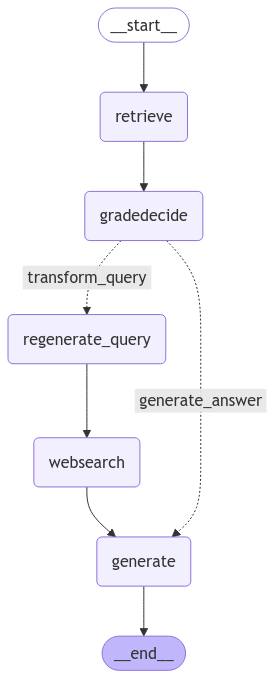

In [492]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [493]:
from pprint import pprint
input={"question":'what is taj mahal'}

In [494]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

==> retrieve_document  <==
==> relevance document are <==
[Document(id='b6e45f27-d62d-4542-a654-038a6331f9e7', metadata={'source': 'sample.txt'}, page_content='Get IBM Certification and a 90% fee refund on completing 90% course in 90 days! Take the Three 90 Challenge today.\n\nMaster Machine Learning, Data Science & AI with this complete program and also get a 90% refund. What more motivation do you need? Start the challenge right away!\n\n\n\nComment\n\nMore info'), Document(id='bfbf5d92-3b27-46b5-8304-3d415de2ea9e', metadata={'source': 'sample.txt'}, page_content='Artificial Intelligence is basically the mechanism to incorporate human intelligence into machines through a set of rules(algorithm). AI is a combination of two words: "Artificial" meaning something made by humans or non-natural things and "Intelligence" meaning the ability to understand or think accordingly. Another definition could be that "AI is\n14 min read\nDifference Between Machine Learning and Deep Learning\nIf you 

In [495]:
from pprint import pprint
input1={"question":'disadvanatge of deep learning'}

In [ ]:
for output in app.stream(input1):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

==> retrieve_document  <==
==> relevance document are <==
[Document(id='8bb59686-2223-436e-ae0f-26cd6e83ad27', metadata={'source': 'sample.txt'}, page_content='Data availability: It requires large amounts of data to learn from. For using deep learning itâ€™s a big concern to gather as much data for training.\nComputational Resources: For training the deep learning model, it is computationally expensive because it requires specialized hardware like GPUs and TPUs.\nTime-consuming: While working on sequential data depending on the computational resource it can take very large even in days or months. \nInterpretability: Deep learning models are complex, it works like a black box. it is very difficult to interpret the result.\nOverfitting: when the model is trained again and again, it becomes too specialized for the training data, leading to overfitting and poor performance on new data.\nAdvantages of Deep Learning:\nHigh accuracy: Deep Learning algorithms can achieve state-of-the-art perfo

In [497]:
y="n"
w=5

for i in range(10):
    if i==w:
        y="y"
        continue
    print(i)

0
1
2
3
4
6
7
8
9


In [498]:
y

'y'

In [519]:
lst1=["nithish","kumar","vijay","kumar"]

In [529]:
name=' '.join([i for i in lst1])

In [530]:
name

'nithish kumar vijay kumar'